# MBAN 6400 Group Project(Part A)

In [160]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from scipy.cluster.vq import whiten,vq,kmeans
import seaborn as sns

### Data Access

In [161]:
# read data
cc_data = pd.read_csv('credit_card.csv')
cc_data.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.90,0.82,95.40,0.00,95.4,0.00,0.17,0.00,0.08,0.00,0.0,2.0,1000.0,201.80,139.51,0.00,12.0
1,C10002,3202.47,0.91,0.00,0.00,0.0,6442.95,0.00,0.00,0.00,0.25,4.0,0.0,7000.0,4103.03,1072.34,0.22,12.0
2,C10003,2495.15,1.00,773.17,773.17,0.0,0.00,1.00,1.00,0.00,0.00,0.0,12.0,7500.0,622.07,627.28,0.00,12.0
3,C10004,1666.67,0.64,1499.00,1499.00,0.0,205.79,0.08,0.08,0.00,0.08,1.0,1.0,7500.0,0.00,NaN,0.00,12.0
4,C10005,817.71,1.00,16.00,16.00,0.0,0.00,0.08,0.08,0.00,0.00,0.0,1.0,1200.0,678.33,244.79,0.00,12.0


In [162]:
# check Tenure's levels
cc_data.TENURE.value_counts()

12.0    7584
11.0     365
10.0     236
6.0      204
8.0      196
7.0      190
9.0      175
Name: TENURE, dtype: int64

In [163]:
# check null value
cc_data.isna().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

### Missing value imputation

In [164]:
data = cc_data.copy()
# payments = 0 and MINIMUM_PAYMENTS = NaN, assign MINIMUM_PAYMENTS to 0, else assign to nan
# drop the row where CREDIT_LIMIT is missing
values = data[(data['PAYMENTS']==0)]['MINIMUM_PAYMENTS'].isna().map({False: np.nan, True: 0})
data['MINIMUM_PAYMENTS'] = data['MINIMUM_PAYMENTS'].fillna(values)
data1 = data.copy().dropna(subset=['CREDIT_LIMIT'])

In [ ]:
# assign all other null value in MINIMUM_PAYMENTS as median value in the column
data1['MINIMUM_PAYMENTS'].fillna(data1['MINIMUM_PAYMENTS'].median(),inplace=True)

In [166]:
# change the type fo Tenure from number to obejct
data1.TENURE = data1.TENURE.astype('object')

### Feature Engineering

In [167]:
# Create new columns
# column1 : Oneoffpurchases_total = purchases-installments_purchases
data1['ONEOFFPURCHASES_TOTAL']=data1['PURCHASES']-data1['INSTALLMENTS_PURCHASES']
# column2 : Total_owed = purchases + cash_advance
data1['TOTAL_OWED'] = data1['PURCHASES'] + data1['CASH_ADVANCE']
# column3 : percent paid = payments/total_owed
data1["PCT_PAID"] = data1['PAYMENTS']//data1['TOTAL_OWED']
# column4: whether fully paid or not (check payments > total owed)
data1['PAID_FULL'] = data1['PAYMENTS'] >= data1['TOTAL_OWED']
# get dummies columns for tenure from 6 months to 12 months
data1 = pd.get_dummies(data1,columns=['TENURE'])

In [168]:
# if data["PCT_PAID"] = inf, then credit used is 0, then that user is not an active user
data1.replace([np.inf, -np.inf], 0, inplace=True)

In [169]:
# drop PRC_FULL_PAYMENT and CUST_ID
data1=data1.drop(columns=['PRC_FULL_PAYMENT','CUST_ID'])

In [170]:
# check error in cash advance frequency
data1[data1['CASH_ADVANCE_FREQUENCY']>1.0]['CASH_ADVANCE_FREQUENCY']

681     1.25
1626    1.17
2555    1.13
2608    1.10
3038    1.50
3253    1.17
8055    1.09
8365    1.14
Name: CASH_ADVANCE_FREQUENCY, dtype: float64

In [171]:
# assign cash advance frequency that is greater than 1 to 1
data1[data1['CASH_ADVANCE_FREQUENCY']>1.0]['CASH_ADVANCE_FREQUENCY'] = 1.0

/var/folders/9s/zz7k8h2949d__gv0rmbn3yj80000gn/T/ipykernel_4576/2911159955.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1[data1['CASH_ADVANCE_FREQUENCY']>1.0]['CASH_ADVANCE_FREQUENCY'] = 1.0


### Outlier Detection and Processing

In [173]:
# outlier percent function
# input: series
# return: percent of outlier data in the series
def outlier_percent(series):
    # Q1 is 25% quantile
    Q1 = series.quantile(0.25)
    # Q2 is 75% quantile
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    minimum = Q1 - (1.5 * IQR)
    maximum = Q3 + (1.5 * IQR)
    num_outliers =  np.sum((series < minimum) |(series > maximum))
    num_total = series.count()
    return (num_outliers/num_total)*100

In [174]:
data1.columns

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'ONEOFFPURCHASES_TOTAL',
       'TOTAL_OWED', 'PCT_PAID', 'PAID_FULL', 'TENURE_6.0', 'TENURE_7.0',
       'TENURE_8.0', 'TENURE_9.0', 'TENURE_10.0', 'TENURE_11.0',
       'TENURE_12.0'],
      dtype='object')

In [175]:
# continuous variable
columns = ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'ONEOFFPURCHASES_TOTAL',
       'TOTAL_OWED', 'PCT_PAID']

Outliers in "BALANCE": 7.77%
Outliers in "BALANCE_FREQUENCY": 16.67%
Outliers in "PURCHASES": 9.03%
Outliers in "ONEOFF_PURCHASES": 11.32%
Outliers in "INSTALLMENTS_PURCHASES": 9.69%
Outliers in "CASH_ADVANCE": 11.51%
Outliers in "PURCHASES_FREQUENCY": 0.0%
Outliers in "ONEOFF_PURCHASES_FREQUENCY": 8.74%
Outliers in "PURCHASES_INSTALLMENTS_FREQUENCY": 0.0%
Outliers in "CASH_ADVANCE_FREQUENCY": 5.87%
Outliers in "CASH_ADVANCE_TRX": 8.98%
Outliers in "PURCHASES_TRX": 8.56%
Outliers in "CREDIT_LIMIT": 2.77%
Outliers in "PAYMENTS": 9.03%
Outliers in "MINIMUM_PAYMENTS": 10.07%
Outliers in "ONEOFFPURCHASES_TOTAL": 11.35%
Outliers in "TOTAL_OWED": 7.03%
Outliers in "PCT_PAID": 11.03%


In [176]:
# rescale each feature dimension of the observation set by its standard deviation
scaler= MinMaxScaler()
data1[columns] = scaler.fit_transform(data1[columns])

In [177]:
# check percentage of outliers after scaling
for column in columns:
    data2 = data1[column]
    percent = str(round(outlier_percent(data2), 2))
    print(f'Outliers in "{column}": {percent}%')

Outliers in "BALANCE": 7.77%
Outliers in "BALANCE_FREQUENCY": 16.67%
Outliers in "PURCHASES": 9.03%
Outliers in "ONEOFF_PURCHASES": 11.32%
Outliers in "INSTALLMENTS_PURCHASES": 9.69%
Outliers in "CASH_ADVANCE": 11.51%
Outliers in "PURCHASES_FREQUENCY": 0.0%
Outliers in "ONEOFF_PURCHASES_FREQUENCY": 8.74%
Outliers in "PURCHASES_INSTALLMENTS_FREQUENCY": 0.0%
Outliers in "CASH_ADVANCE_FREQUENCY": 5.87%
Outliers in "CASH_ADVANCE_TRX": 10.66%
Outliers in "PURCHASES_TRX": 8.88%
Outliers in "CREDIT_LIMIT": 2.77%
Outliers in "PAYMENTS": 9.03%
Outliers in "MINIMUM_PAYMENTS": 10.07%
Outliers in "ONEOFFPURCHASES_TOTAL": 11.35%
Outliers in "TOTAL_OWED": 7.03%
Outliers in "PCT_PAID": 11.03%


/var/folders/9s/zz7k8h2949d__gv0rmbn3yj80000gn/T/ipykernel_4576/2470981135.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(df_corr, dtype=np.bool))


Text(0.5, 1.0, 'Correlation Heatmap')

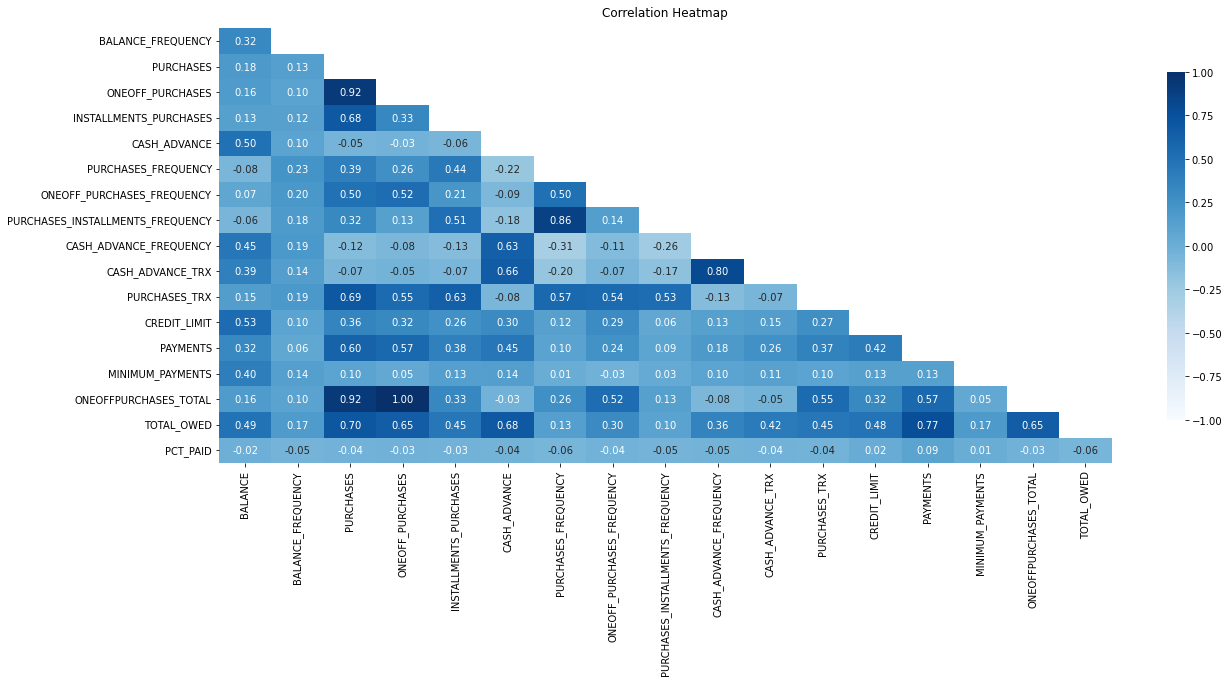

In [193]:
# plot the pearson correlations of all variables
fig, ax = plt.subplots(figsize=(20, 8))
data2 = data1[columns]
df_corr = data2.corr()
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
# adjust mask and df
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()
# create a heatmap
heatmap = sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='Blues',
           vmin=-1, vmax=1, cbar_kws={"shrink": .8})
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

In [194]:
from scipy.stats import pearsonr
import pandas as pd
# build a function which calculates the p value of pearson correlation analysis
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

In [195]:
calculate_pvalues(data1[columns])

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,ONEOFFPURCHASES_TOTAL,TOTAL_OWED,PCT_PAID
BALANCE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1437
BALANCE_FREQUENCY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PURCHASES,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0004
ONEOFF_PURCHASES,0.0,0.0,0.0,0.0,0.0,0.003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0056
INSTALLMENTS_PURCHASES,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001
CASH_ADVANCE,0.0,0.0,0.0,0.003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0031,0.0,0.0002
PURCHASES_FREQUENCY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4541,0.0,0.0,0.0
ONEOFF_PURCHASES_FREQUENCY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0125,0.0,0.0,0.0005
PURCHASES_INSTALLMENTS_FREQUENCY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0015,0.0,0.0,0.0
CASH_ADVANCE_FREQUENCY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [196]:
# Fino out all insiginificant correlation pairs
p_value = calculate_pvalues(data2[columns])
insignificant=[]
for column in p_value.columns:
    for i in p_value.index:
        if p_value[column][i]>0.05:
            insignificant.append([column,i])



In [197]:
# output 
insignificant

[['BALANCE', 'PCT_PAID'],
 ['PURCHASES_FREQUENCY', 'MINIMUM_PAYMENTS'],
 ['CREDIT_LIMIT', 'PCT_PAID'],
 ['MINIMUM_PAYMENTS', 'PURCHASES_FREQUENCY'],
 ['MINIMUM_PAYMENTS', 'PCT_PAID'],
 ['PCT_PAID', 'BALANCE'],
 ['PCT_PAID', 'CREDIT_LIMIT'],
 ['PCT_PAID', 'MINIMUM_PAYMENTS']]

In [198]:
# Cleanded data to csv
data1.to_csv('new_data.csv')